# Heatmap visualization 
In this notebook, the visualization of the areas of the input images that are crucial for the classification result is done. 

sources: 
    - https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759
    - https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import random

In [2]:
import efficientnet.tfkeras
from tensorflow.keras.models import load_model

model_species = load_model('./model_species_wo_bell_strawberry_raspberry_augmented.h5')
model_diseases = load_model('model_diseases_reduced_labels_augmented.h5')

In [3]:
# efficientNet uses 224x224x3 as input shape
DIM = 224

In [4]:
# label maps were copied from the notebook in which the models are trained
label_map_diseases = {'apple_scab_leaf': 0,
 'grape_leaf_black_rot': 1,
 'healthy': 2,
 'leaf_blight': 3,
 'peach_leaf_bacterial_spot': 4,
 'peach_leaf_curl': 5,
 'rust_leaf': 6,
 'squash_powdery_mildew_leaf': 7,
 'tomato_leaf_spot': 8,
 'tomato_mold_leaf': 9}

label_map_species = {'apple': 0,
 'corn': 1,
 'grape': 2,
 'peach': 3,
 'potato': 4,
 'soybean': 5,
 'squash': 6,
 'tomato': 7}

In [5]:
# base algorithm from medium article. Some modifications are done based on the githuib repo from fchollet.

def gradCAM(orig, model_type, intensity=0.5, res=250):
    img = image.load_img(orig, target_size=(DIM, DIM))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    
    if model_type == 'species': 
        preds = model_species.predict(x)
        with tf.GradientTape() as tape:
            last_conv_layer = model_species.get_layer('top_conv')
            iterate = tf.keras.models.Model([model_species.inputs], [model_species.output, last_conv_layer.output])
            model_out, last_conv_layer = iterate(x)
            class_out = model_out[:, np.argmax(model_out[0])]
            grads = tape.gradient(class_out, last_conv_layer)
            pooled_grads = K.mean(grads, axis=(0, 1, 2))
            label = list(label_map_species.keys())[list(label_map_species.values()).index(np.argmax(preds[0]))]
            
    elif model_type == 'diseases': 
        preds = model_diseases.predict(x)
        with tf.GradientTape() as tape:
            last_conv_layer = model_diseases.get_layer('top_conv')
            iterate = tf.keras.models.Model([model_diseases.inputs], [model_diseases.output, last_conv_layer.output])
            model_out, last_conv_layer = iterate(x)
            class_out = model_out[:, np.argmax(model_out[0])]
            grads = tape.gradient(class_out, last_conv_layer)
            pooled_grads = K.mean(grads, axis=(0, 1, 2))
            label = list(label_map_diseases.keys())[list(label_map_diseases.values()).index(np.argmax(preds[0]))]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape((7, 7))

    img = cv2.imread(orig)
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)

    # We apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.4 + img
    cv2.imwrite('./test_heatmap.jpg', superimposed_img)
    
    
    img = cv2.imread(orig)
    fig = plt.figure(figsize=(10,10))
    
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax2 = fig.add_subplot(2,2,2)
    
    img = image.load_img('./test_heatmap.jpg')
    ax2.imshow(img)
    
#    fig.suptitle(label, fontsize=20)
    plt.show()
#    print(orig)
    
    """
    img = cv2.imread(orig)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    print(orig)
    print(label)
    cv2.imwrite('./test_heatmap.jpg', superimposed_img)
    img = image.load_img('./test_heatmap.jpg')
    plt.imshow(img)
    """

In [6]:
list_imgs = os.listdir('./augmented_images')

In [7]:
test_img = random.choice(list_imgs)
print(test_img)

flip_v_tomato mold leaf_Image_72.1.jpg


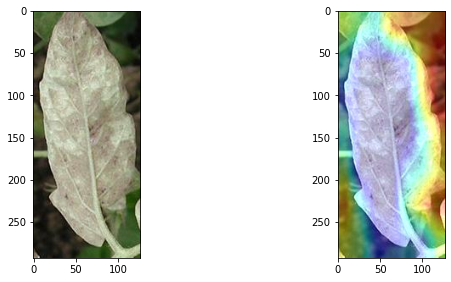

In [8]:
gradCAM('augmented_images/' + test_img, 'species')

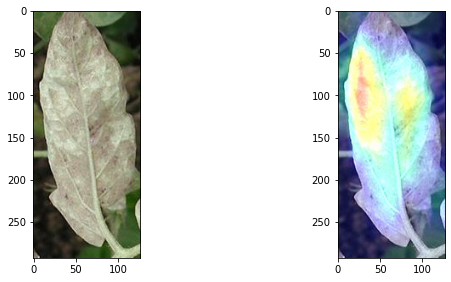

In [9]:
gradCAM('augmented_images/' + test_img, 'diseases')

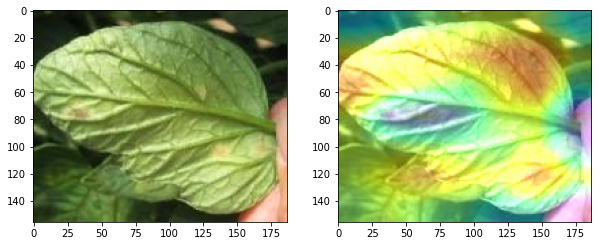

In [10]:
gradCAM('augmented_images/tomato mold leaf_Image_979.jpg', 'species')

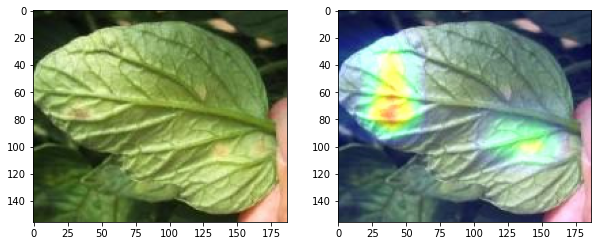

In [11]:
gradCAM('augmented_images/tomato mold leaf_Image_979.jpg', 'diseases')